## 1. Introduction - Sentiment Analysis

Sentiment analysis (or opinion mining) is a natural language processing (NLP) technique used to determine whether data is positive, negative or neutral. Sentiment analysis is often performed on textual data to help businesses monitor brand and product sentiment in customer feedback, and understand customer needs.

Sentiment analysis typically focuses on the polarity of a text (positive, negative, neutral) but it also goes beyond polarity to detect specific feelings and emotions (angry, happy, sad, etc), urgency (urgent, not urgent) and even intentions (interested v. not interested). 

Since humans express their thoughts and feelings more openly than ever before, sentiment analysis is fast becoming an essential tool to monitor and understand sentiment in all types of data.

**In this notebook we will be using sentient analysis to analyze the sentiment of different opinions/titles of financial news.**

## 2. Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-sentiment-analysis/data.csv


## 3. Import Dataset

In [2]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')

## 4. Exploratory Data Analysis

In [40]:
df.head()

Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral

In [41]:
df.isna().any()

Sentence     False
Sentiment    False
dtype: bool

In [42]:
df.shape

(5842, 2)

In [43]:
df.describe()

Sentence Sentiment
count                                                5842      5842
unique                                               5322         3
top     Managing Director 's comments : `` Net sales f...   neutral
freq                                                    2      3130

* More than 3000 neutral sentiments...is there an imbalance?

<AxesSubplot:>

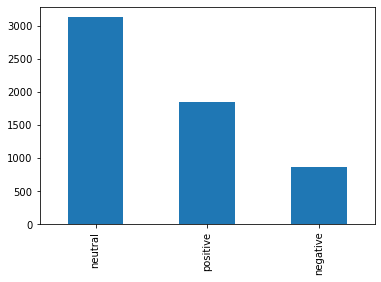

In [44]:
df['Sentiment'].value_counts().plot(kind='bar')

* **There are a lot more neutral sentiments than positive and negative sentiments, and there are a lot more positive sentiments than negative; maybe we need to keep this in mind...**

* For now, as we have become aware that we have three target variables (neutral, positive, negative), let us one-hot encode them for the purposes of running a model later on.

In [3]:
df_ohe = pd.get_dummies(df, columns = ['Sentiment'])
df_ohe.head()

Sentence  Sentiment_negative  \
0  The GeoSolutions technology will leverage Bene...                   0   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...                   1   
2  For the last quarter of 2010 , Componenta 's n...                   0   
3  According to the Finnish-Russian Chamber of Co...                   0   
4  The Swedish buyout firm has sold its remaining...                   0   

   Sentiment_neutral  Sentiment_positive  
0                  0                   1  
1                  0                   0  
2                  0                   1  
3                  1                   0  
4                  1                   0

## 5. Sentiment Analysis - LSTM-based model

The LSTM (Long Short Term Memory) model is a type of RNN (recurrent neural network), which at its base is a traditional neural network with loops that allow information to persist within the neural network. The problem with RNNs is that once a lot of information has been allowed to persist in the neural network, the traditional RNNs are not built to be able to connect previous long-ago learned information to where it is currently needed (imagine someone struggling to recall something); LSTMs are the solution to this (see https://colah.github.io/posts/2015-08-Understanding-LSTMs/ for more in-depth discussion on why this is the case).

#### 5A. Import necessary libraries

First let us import necessary libraries:

In [4]:
#Importing necessary libraries
import nltk
from textblob import Word
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization
#!pip install keras_visualizer
from keras.utils.vis_utils import plot_model
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade
import visualkeras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import keras
from keras import backend as K
import tensorflow as tf

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-4s9orr1x
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-4s9orr1x
  Resolved https://github.com/paulgavrikov/visualkeras to commit d7111d3471173c0b16853a6ce5e4cc645498380a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 2.4 MB/s eta 0:00:0000:0100:01
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13449 sha256=e3e71c5f535899cbc43d4f31fddf7b4c28f926b52f73984808529dad7837eda1
  Stored in directory: /tmp/pip-ephem-wheel-cache-7wadt7yj/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


#### 5B. Preprocess the data

Then we need to clean the data; common cleaning techniques for natural language processing are lowercasing the data, removing numbers, removing stop words (common connecting words, like articles or pronouns), lemmatization (which is the process of removing inflectional endings and to return to the base/dictionary form of a word), and removing punctuation, as done below:

In [6]:
#Pre-Processing the text

import string

def cleaning(df, stop_words):
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['Sentence'] = df['Sentence'].str.replace('\d+', '')
    # Removing stop words
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    # Remove punctuation
    df['Sentence'] = df['Sentence'].str.replace('[{}]'.format(string.punctuation), '')
    return df
stop_words = stopwords.words('english')
data_cleaned = cleaning(df_ohe, stop_words)
data_cleaned.head()

Sentence  Sentiment_negative  \
0  geosolutions technology leverage benefon gps s...                   0   
1                        esi low bk real possibility                   1   
2  last quarter componenta net sale doubled eurm ...                   0   
3  according finnishrussian chamber commerce majo...                   0   
4  swedish buyout firm sold remaining percent sta...                   0   

   Sentiment_neutral  Sentiment_positive  
0                  0                   1  
1                  0                   0  
2                  0                   1  
3                  1                   0  
4                  1                   0

* Looks a little cleaner and less convoluted; now let us count the amount of words in the cleaned dataset, and compare it to the original dataset...

In [7]:
from collections import Counter

results = Counter()
data_cleaned['Sentence'].str.lower().str.split().apply(results.update)
print("Number of 'words' in cleaned dataset: ", len(results))

results_2 = Counter()
df['Sentence'].str.lower().str.split().apply(results_2.update)
print("Number of 'words' in original dataset: ", len(results_2))

Number of 'words' in cleaned dataset:  9791
Number of 'words' in original dataset:  14098


* **The cleaning affected maybe a third of the words/characters in the dataset; this should prime us for much more accuracy than before, being rid of stop words and numbers and punctuations...**

* Now let us employ tokenization, which essentially turns sentences into numerical vectors which can be run through a machine learning model. See below:

In [8]:
#Generating Embeddings using tokenizer
tokenizer = Tokenizer(num_words=9959, split=' ') 
tokenizer.fit_on_texts(data_cleaned['Sentence'].values)
#print("Word index: ", tokenizer.word_index)
X = tokenizer.texts_to_sequences(data_cleaned['Sentence'].values)
longest = 0
shortest = len(X[0])
for value in X:
    longest = max(longest, len(value))
    shortest = min(shortest, len(value))
print("Longest text to sequences: ", longest)
print("Shortest text to sequences: ", shortest)
X = pad_sequences(X)
print("Padded sequences: ", X)

Longest text to sequences:  38
Shortest text to sequences:  0
Padded sequences:  [[   0    0    0 ... 3260  437  247]
 [   0    0    0 ... 3261  322 2565]
 [   0    0    0 ...  166   25   70]
 ...
 [   0    0    0 ...  282   46  813]
 [   0    0    0 ...   47    1    3]
 [   0    0    0 ...  155 3252  159]]


In tokenization...

1.  We first create a tokenizer instance based on the total number of words in our cleaned dataset.

2. We then fit it on the dataset and generate a word index, based on each individual and unique word found in the dataset.

3.  We then translate the sentences into numerical sequences based on the word indexes generated in the fit_on_texts stage.

4.  We then pad those sequences, which is essentially creating length equality between sequences for analysis purposes (a 3 word sentence becomes even with a 12 word sentence by adding 9 zeroes to the 3 word sentence). **Due to the widely differing lengths of sentences (longest text to sequences is 38, while shortest is 1), we need to keep an eye on these padded sequences, as weight inequality can be possible.**

These padded sequences become the input for our model (X). Now let us create the target:

In [9]:
#encoder = LabelEncoder()
#labels = encoder.fit_transform(df.Sentiment)
#y = labels
y = data_cleaned[['Sentiment_negative', 'Sentiment_neutral', 'Sentiment_positive']].values
len(y)

5842

* We now have our target value, based off of the one-hot encoding done earlier.

* **We mentioned that we had way more neutral instances than positive or negative; through trial and error, and theory, we have decided the best option is to oversample the dataset, which duplicates instances in the minority classes to create equality of occurrence between target classes in the dataset.**

In [10]:
import collections
from imblearn import over_sampling

#print('Original dataset shape %s' % collections.Counter(y))

rus = over_sampling.RandomOverSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = rus.fit_resample(X, y)
len(y_res)
#print('Resampled dataset shape %s' % collections.Counter(y_res))

9390

* It is made evident that the length of y has increased dramatically due to the oversampling, which was the desired outcome (9390 is exactly three times 3130, which was the amount of neutral instances in the original dataset (see df.describe above).

* **We have cleaned, tokenized, and oversampled the initially imbalanced dataset...now let us build and run a neural network!**

#### 5C. Model building

Now we need to start building out a neural network.

In [42]:
#Model Building

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
initializer=tf.keras.initializers.RandomUniform()

model = Sequential()
model.add(Embedding(9959, 20, input_length = X_res.shape[1])) #500, 120, 38 (sentence length)
model.add(SpatialDropout1D(0.7))
model.add(LSTM(16, dropout=0.7, kernel_initializer=initializer)) #704 , recurrent_dropout=0.65
model.add(BatchNormalization())
model.add(Dense(1, activation='softsign',  kernel_initializer=initializer)) #',
model.add(Dense(3, activation='softmax', kernel_initializer=initializer)) #3 
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 38, 20)            199180    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 38, 20)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                2368      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 6         
Total params: 201,635
Trainable params: 201,603
Non-trainable params: 32
_______________________________________________

*  Because it is a large enough database, we will embed the data, which essentially changes each word from a one-hot encoded vector to a 'latent factors' vector with less dimensions and no zeroes. 9664 is for number of words in the dictionary and 38 is for length of vector of padded sequences.

* Spatial dropout layer, drops entire 1d feature maps instead of individual elements.

* Create an instance of an LSTM neural network, with additional dropout.

* Use batch normalization, a technique designed to automatically standardize the inputs to a layer in a deep learning neural network (which seemed appropriate due to padded sequences).

* Create a dense hidden layer with the softsign activation function.

* Create a dense output layer with the softmax activation function (multiclass classification problem).

* Use Adam optimizer and test for accuracy.

* **Let's visualize this model below:**

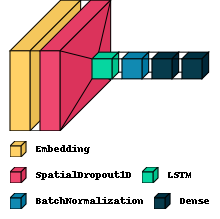

In [26]:
visualkeras.layered_view(model, legend=True)

In [43]:
# Spliting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.05)


from tensorflow.keras.utils import to_categorical
#import tensorflow as tf
#tf.config.run_functions_eagerly(True)
#y_train = to_categorical(y_train, 3)
#y_test = to_categorical(y_test, 3)

# Records the weights throughout the training process
weights_history = []
# A custom callback
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
class MyCallback(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs):
        weights = model.get_weights()[11]
        w1, w2, w3 = weights
        weights = [w1, w2, w3]
        #print('on_batch_end() model.weights:', weights)
        weights_history.append(weights)
callback = MyCallback()

#Model Training
history = model.fit(X_train, y_train, epochs = 100, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=[callback])

#Model Testing
model.evaluate(X_test,y_test)

Epoch 1/100
35/35 [==============================] - 2s 20ms/step - loss: 1.0986 - accuracy: 0.3346 - val_loss: 1.0986 - val_accuracy: 0.3340
Epoch 2/100
35/35 [==============================] - 0s 9ms/step - loss: 1.0875 - accuracy: 0.4177 - val_loss: 1.0905 - val_accuracy: 0.3830
Epoch 3/100
35/35 [==============================] - 0s 9ms/step - loss: 1.0506 - accuracy: 0.4703 - val_loss: 1.0693 - val_accuracy: 0.4383
Epoch 4/100
35/35 [==============================] - 0s 9ms/step - loss: 1.0182 - accuracy: 0.4812 - val_loss: 1.0655 - val_accuracy: 0.3894
Epoch 5/100
35/35 [==============================] - 0s 9ms/step - loss: 0.9871 - accuracy: 0.4998 - val_loss: 1.0217 - val_accuracy: 0.4532
Epoch 6/100
35/35 [==============================] - 0s 9ms/step - loss: 0.9618 - accuracy: 0.5101 - val_loss: 0.9708 - val_accuracy: 0.5255
Epoch 7/100
35/35 [==============================] - 0s 9ms/step - loss: 0.9466 - accuracy: 0.5253 - val_loss: 1.0346 - val_accuracy: 0.4426
Epoch 8/100


[0.8851698040962219, 0.6319149136543274]

#### 5C. Model Analysis

Let's see how the model performed.

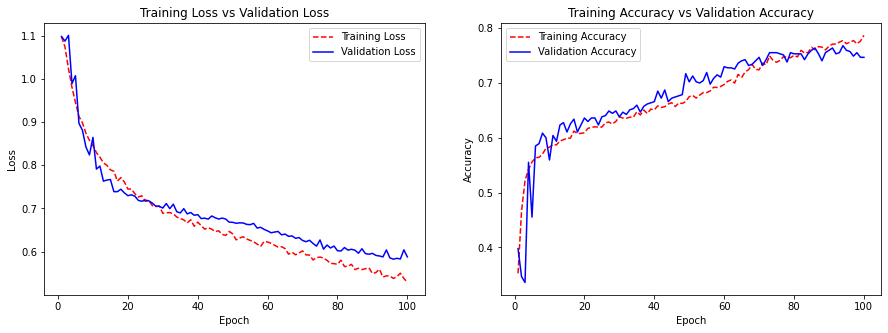

In [34]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,5))

# Visualize loss history
ax1 = plt.subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')

ax2 = plt.subplot(122)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy']) #, 'Test Loss'
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')

plt.show();

* Training and validation data basically mirror each other, with training data slightly outperforming.

* Loss/Accuracy per epoch is seemingly more erratic while the model is running on validation data, but the learning trend still obviously occurs.

In [ ]:
import os
import tensorflow as tf
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #If the line below doesn't work, uncomment this line (make sure to comment the line below); it should help.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#Your Code Here

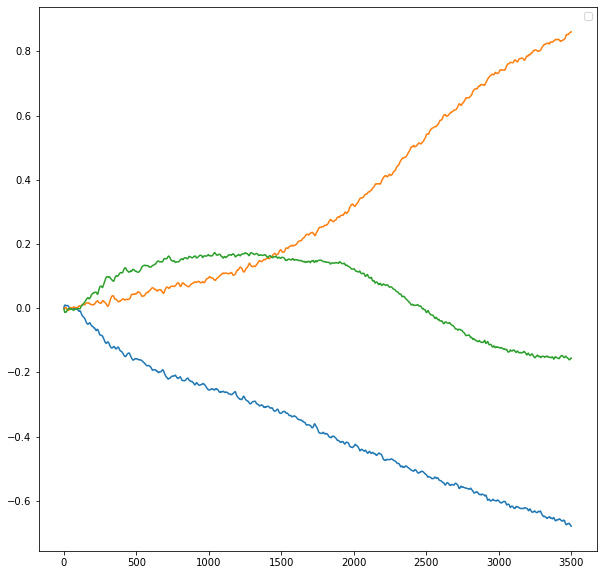

In [35]:
#changing weights of the output layer
plt.figure(1, figsize=(10, 10))
plt.plot(weights_history)
plt.legend()
plt.show()

In [55]:
len(model.get_weights()[11])

3

In [36]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(X_test, verbose=0), axis=-1)
#print(yhat_classes)
#print(np.argmax(y_test, axis=-1))
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.argmax(y_test, axis=-1), yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.argmax(y_test, axis=-1), yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.argmax(y_test, axis=-1), yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.argmax(y_test, axis=-1), yhat_classes, average='weighted')
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(np.argmax(y_test, axis=-1), yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(np.argmax(y_test, axis=-1), yhat_probs, multi_class='ovr')
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(np.argmax(y_test, axis=-1), yhat_classes)
print(matrix)

Accuracy: 0.746809
Precision: 0.748811
Recall: 0.746809
F1 score: 0.747409
Cohens kappa: 0.620219
ROC AUC: 0.889263
[[115  42   0]
 [ 30 102  25]
 [  2  20 134]]


In [37]:
print(classification_report(np.argmax(y_test, axis=-1), yhat_classes))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76       157
           1       0.62      0.65      0.64       157
           2       0.84      0.86      0.85       156

    accuracy                           0.75       470
   macro avg       0.75      0.75      0.75       470
weighted avg       0.75      0.75      0.75       470



* Interestingly, low recall for the 1 class (the neutral class, which was initially the class with significantly more instances than others).

## 6. Conclusion

We ran sentiment analysis on a dataset of financial article titles, and generated a validation loss around 0.6 and a valifation accuracy of around 0.75. The modelwas most successful in calling out the positive article titles (2 class; 0.85 f1-score), and least successful at calling out the neutral titles (1 class; 0.64 f1-score).